In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc
import os
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from data import MemmapDataset
from models import *
from torchgeo.models import get_weight
from typing import List

/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In DroneClassification/, we have trained ResNet UNet weights on a 3cm/pixel drone dataset

We want to tune the model's decoder weights on our new dataset of 1m/pixel drone images in the process described below.

1. We load in the original model weights trained on 3cm/pixel data as-is and benchmark performance on a 1m/pixel drone dataset vs a 3cm/pixel drone dataset. We expect metrics of the 1m/pixel drone dataset to be bad and metrics of the 3cm/pixel drone dataset to be good

2. We train our ResNet UNet model with 3cm/pixel weights on our 1m/pixel data and visualize the loss curve and evaluation metrics across epochs

In [2]:
LOSS = JaccardLoss()
BATCH_SIZE = 32
INIT_LR = 0.005
NUM_EPOCHS = 30
DATA_SPLIT = 0.80

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Metal Performance Shaders (MPS) device.\n")
else:
    DEVICE = torch.device("cpu")
    print("WARNING: No GPU found. Defaulting to CPU.")

Using Apple Metal Performance Shaders (MPS) device.



In [3]:
# Training Functions
def train(model, dataset, log_every_x_epochs = 10 , save_model_every_x_epochs = 100):
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()

    save_dir = "decode_tune"
    os.makedirs(save_dir, exist_ok=True)

    opt = Adam(model.parameters(), lr=INIT_LR)
    print("[INFO] training the network...")
    training_loss = []
    all_metrics = []

    # train_ds, valid_ds = dataset.split(DATA_SPLIT)
    n_train = int(len(dataset) * DATA_SPLIT)
    n_val = len(dataset) - n_train

    train_ds, valid_ds = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_train_loss = 0
        
        for batch_idx, (x, y) in enumerate(train_loader):
            # print(f" Batch {batch_idx + 1}/{len(train_loader)}", end="\r")
            
            # Send the input to the device
            x = x.to(DEVICE)
            y = y.float().to(DEVICE)

            # Perform a forward pass and calculate the training loss
            pred = model(x)
            if isinstance(pred, tuple):
                pred = pred[0]
            loss = LOSS(pred, y)

            # Zero out any previously accumulated gradients, perform backpropagation, and update model parameters
            opt.zero_grad()
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        training_loss.append(avg_train_loss)

        # Evaluate on validation dataset
        metrics = evaluate(model, test_loader)
        all_metrics.append(metrics)
        avg_test_loss = metrics['Loss']

        # Print Epoch Metrics
        if (epoch + 1) % log_every_x_epochs == 0 or epoch == NUM_EPOCHS-1:
          print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}")
          print(f"Train loss: {avg_train_loss:.6f}, Test loss: {avg_test_loss:.4f}")
          print("\nValidation Metrics:")
          for k, v in metrics.items():
              if k != 'Loss':
                  print(f"{k}: {v}")
          print("\n")

        # --- save model checkpoint ---
        if (epoch + 1) % save_model_every_x_epochs == 0 or epoch == NUM_EPOCHS-1:
            # Save model in current directory
            try:
                model_filename = (
                    f"{model.__class__.__name__}_epoch_{epoch+1:06d}.pth"
                )
                save_path = os.path.join(save_dir, model_filename)
                torch.save(model.state_dict(), save_path)
                print(f"Saved model to {save_path}")
            except Exception as exc:
                print(f"Error saving model: {str(exc)}")

        # --- save metrics ---
        if (epoch + 1) % save_model_every_x_epochs == 0 or epoch == NUM_EPOCHS-1:
            train_loss_path = os.path.join(save_dir, "train_losses.npy")
            eval_metrics_path = os.path.join(save_dir, "eval_metrics.npy")
            np.save(train_loss_path, np.array(training_loss, dtype=np.float32))
            np.save(eval_metrics_path, np.array(all_metrics, dtype=object))
            print(f"Saved metrics to {train_loss_path} and {eval_metrics_path}")

    return training_loss, all_metrics

def evaluate(model: nn.Module, dataloader: DataLoader):
    model.eval()
    total_loss = 0
    total_TP = 0
    total_FP = 0
    total_FN = 0
    total_TN = 0

    with torch.no_grad():
        for (x, y) in dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).float()
            
            pred = model(x)
            if isinstance(pred, tuple):
                pred = pred[0]
            loss = LOSS(pred, y)
            total_loss += loss.item()

            pred = torch.sigmoid(pred).view(-1)
            y = y.view(-1)
            
            TP = (pred * y).sum().item()
            FP = ((1 - y) * pred).sum().item()
            FN = (y * (1 - pred)).sum().item()
            TN = ((1 - y) * (1 - pred)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN
            
            del x, y, pred, loss

    avg_loss = total_loss / len(dataloader)
    precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = total_TP / (total_TP + total_FP + total_FN) if (total_TP + total_FP + total_FN) > 0 else 0
    accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN) if (total_TP + total_FP + total_FN + total_TN) > 0 else 0
    specificity = total_TN / (total_TN + total_FP) if (total_TN + total_FP) > 0 else 0

    metrics = {
        'Loss': avg_loss,
        'Precision': precision,
        'Recall': recall,
        'f1_score': f1_score,
        'IOU': iou,
        'Accuracy': accuracy,
        'Specificity': specificity
    }

    return metrics

# Plotting functions
def plot_losses(title, training_loss, validation_loss, training_time=None, y_max=0.3):
  # scale losses to fit graph
  valid_loss = [min(x,y_max) for x in validation_loss]
  train_loss = [min(x, y_max) for x in training_loss]

  epochs = len(train_loss)

  plt.figure()
  plt.plot(np.arange(1, epochs+1), train_loss, label="train_loss")
  plt.plot(np.arange(1, epochs+1), valid_loss, label="valid_loss")
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")
  if training_time is not None:
    plt.text(0, 0.3, f"Training Time: {training_time}")

  step = y_max / 10
  yticks = np.arange(0, y_max+step, step)  # Generate ticks from 0.025 to 0.3 with step 0.025
  plt.yticks(yticks)

  max_ticks = 10
  step = max(1, epochs // max_ticks)
  xticks = np.arange(2, epochs+2, step)  # Generate ticks from 0 to num_epochs with step 2
  plt.xticks(xticks)
  
  plt.show()

def plot_metrics(title: str, metric_dict: dict, metrics: List = ['Precision', 'Recall', 'IOU']):
    epochs = len(metric_dict)
    plt.figure()
    for metric in metrics:
        plt.plot(np.arange(0, epochs), [x[metric] for x in metric_dict], label=metric)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend(loc="lower right")

    yticks = np.arange(0.0, 1.1, 0.1)
    plt.yticks(yticks)

    max_ticks = 10
    step = max(1, epochs // max_ticks)
    xticks = np.arange(2, epochs+2, step)
    plt.xticks(xticks)
    
    plt.show()

2. Tune ResNet UNet model on 1mdrone:label pairs

In [4]:
class DroneDataset(Dataset):
    def __init__(self, images, labels, mean=None, std=None):
        self.images = images
        self.labels = labels

        if mean is not None and std is not None:
            self.mean = torch.tensor(mean).view(3, 1, 1)
            self.std = torch.tensor(std).view(3, 1, 1)
        else:
            self.mean = None
            self.std = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.mean is not None and self.std is not None:
            img = (img - self.mean) / self.std

        return img, label


In [5]:

# Get evaluation metrics for 1m/pixel drone data
orig_RNUN = ResNet_UNet().to(DEVICE)
ckpt_path = '/Users/evanwu/ml-mangrove/DroneClassification/moco_resnet18_unet.pth'
ckpt = torch.load(ckpt_path, map_location=DEVICE)
# print(f"ckpt.keys()={ckpt.keys()}")
orig_RNUN.load_state_dict(ckpt)

# dataset = MemmapDataset(np.load('/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224dataset_drone.npy', 'r'), np.load('/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224dataset_label.npy', 'r'))
dataset = DroneDataset(np.load('/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224dataset_drone.npy', 'r'), np.load('/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224dataset_label.npy', 'r'))
print(f"Dataset containing {len(dataset)} images loaded.")
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

orig_metrics = evaluate(orig_RNUN, loader)
print(f"1m/pixel metrics on original model: {orig_metrics}")

# Get evaluation metrics for 3cm/pixel drone data
orig_RNUN = ResNet_UNet().to(DEVICE)
ckpt_path = '/Users/evanwu/ml-mangrove/DroneClassification/moco_resnet18_unet.pth'
ckpt = torch.load(ckpt_path, map_location=DEVICE)
# print(f"ckpt.keys()={ckpt.keys()}")
orig_RNUN.load_state_dict(ckpt)

# small_dataset = MemmapDataset(np.load('/Users/evanwu/Downloads/Drone Classification/224_image_small.npy', 'r'), np.load('/Users/evanwu/Downloads/Drone Classification/224_label_small.npy', 'r'))
small_dataset = DroneDataset(np.load('/Users/evanwu/Downloads/Drone Classification/224_image_small.npy', 'r'), np.load('/Users/evanwu/Downloads/Drone Classification/224_label_small.npy', 'r'))
print(f"Dataset containing {len(small_dataset)} images loaded.")
small_loader = DataLoader(small_dataset, batch_size=BATCH_SIZE, shuffle=False)

small_metrics = evaluate(orig_RNUN, small_loader)
print(f"3cm/pixel metrics on original model: {small_metrics}")

del orig_RNUN
gc.collect()


Dataset containing 584 images loaded.
1m/pixel metrics on original model: {'Loss': 0.5966341244546991, 'Precision': 0.4097883251111667, 'Recall': 0.9998476882805086, 'f1_score': 0.5813215690494663, 'IOU': 0.4097627456420641, 'Accuracy': 0.4127038191164393, 'Specificity': 0.008413921050496704}
Dataset containing 5000 images loaded.
3cm/pixel metrics on original model: {'Loss': 0.7559953476213346, 'Precision': 0.24818531292444668, 'Recall': 0.9955900052711396, 'f1_score': 0.39732387898022875, 'IOU': 0.24791277150084098, 'Accuracy': 0.29045420244880915, 'Specificity': 0.07393333304164272}


30

In [8]:
# Tune decoder weights with 1m/pixel drone:label dataset
model = ResNet_UNet().to(DEVICE)
ckpt_path = '/Users/evanwu/ml-mangrove/DroneClassification/moco_resnet18_unet.pth'
ckpt = torch.load(ckpt_path, map_location=DEVICE)
# print(f"ckpt.keys()={ckpt.keys()}")
model.load_state_dict(ckpt)

# check trainable parameters
# for name, param in model.named_parameters():
#     print(f"{name:40s}  requires_grad={param.requires_grad}")

# dataset = MemmapDataset(np.load('/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224dataset_drone.npy', 'r'), np.load('/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224dataset_label.npy', 'r'))
dataset = DroneDataset(np.load('/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224dataset_drone.npy', 'r'), np.load('/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224dataset_label.npy', 'r'))
print(f"Dataset containing {len(dataset)} images loaded.")

train_loss, valid_metrics = train(model, dataset, save_model_every_x_epochs = 100)

del model
gc.collect()

Dataset containing 584 images loaded.
[INFO] training the network...
Epoch: 10/30
Train loss: 0.231124, Test loss: 0.2454

Validation Metrics:
Precision: 0.8550146332641103
Recall: 0.8659200059482545
f1_score: 0.8604327665352318
IOU: 0.7550522174274447
Accuracy: 0.8950183528978639
Specificity: 0.9123817432416048


Epoch: 20/30
Train loss: 0.197912, Test loss: 0.2260

Validation Metrics:
Precision: 0.8752239268620302
Recall: 0.8707000505667485
f1_score: 0.8729561277900308
IOU: 0.7745538122471582
Accuracy: 0.9052893169328236
Specificity: 0.925929216801028


Epoch: 30/30
Train loss: 0.180513, Test loss: 0.2154

Validation Metrics:
Precision: 0.8743851530978981
Recall: 0.8848491865765349
f1_score: 0.8795860494815673
IOU: 0.7850545319206078
Accuracy: 0.9094607651000343
Specificity: 0.9241468386879862


Saved model to decode_tune/ResNet_UNet_epoch_000030.pth
Saved metrics to decode_tune/train_losses.npy and decode_tune/eval_metrics.npy


8094

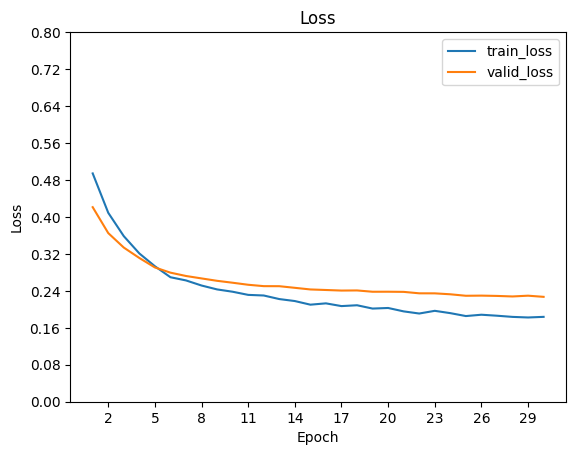

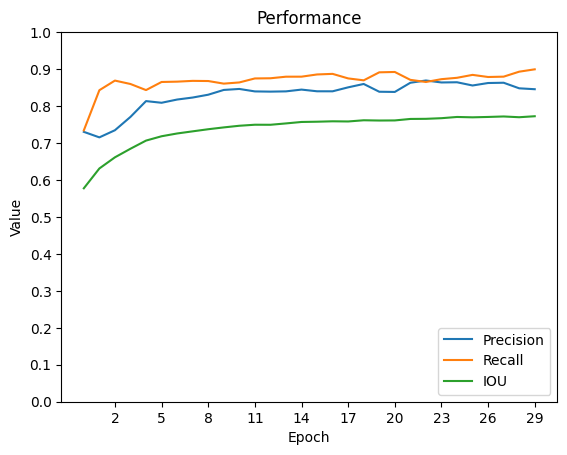

In [7]:
loaded_train_losses = np.load("decode_tune/train_losses.npy")
loaded_eval_metrics = np.load("decode_tune/eval_metrics.npy", allow_pickle=True)
loaded_eval_losses = [m['Loss'] for m in loaded_eval_metrics]

plot_losses("Loss", loaded_train_losses, loaded_eval_losses, y_max=0.8)
plot_metrics("Performance", loaded_eval_metrics)